Analyses how kappa controls the covariance versus variance constraint

In [1]:
import numpy as np
import torch
from decorrelation.decorrelation import lower_triangular, Decorrelation, DecorConv2d # DecorrelationPatch2d # covariance, DecorrelationPatch2d, DecorrelationFC, lower_triangular
from decorrelation.plotting import *
from decorrelation.utils import generate_correlated_data

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def train(num_epochs, data, model):

    # covariance matrix before training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A1 = (X.T @ X) / len(X)

    # train decorrelator
    L = np.zeros(num_epochs)
    for epoch in range(num_epochs):
        model.forward(data)
        L[epoch] = model.update()
        print(f'epoch {epoch:<3}\tloss: {L[epoch]:3f}')

    # covariance matrix after training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A2 = (X.T @ X) / len(X)

    return L, A1, A2

In [3]:
num_samples=1000
num_features=100
num_epochs=300
seed=40
decor_lr=1e-2

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# generate correlated data
data = 0.5 * generate_correlated_data(num_features, num_samples, strength=0.5).to(device)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

kappas = np.linspace(0, 1.0, 30)
D = np.zeros(len(kappas))
C = np.zeros(len(kappas))
for i, kappa in enumerate(kappas):

    model = Decorrelation(in_features=num_features, decor_lr=decor_lr, kappa=kappa).to(device)

    L, A1, A2 = train(num_epochs, data, model)
    
    C[i] = torch.mean(lower_triangular(torch.abs(A2), offset=-1))
    D[i] = torch.mean(torch.diag(A2))


epoch 0  	loss: 0.014729
epoch 1  	loss: 0.014657
epoch 2  	loss: 0.014585
epoch 3  	loss: 0.014514
epoch 4  	loss: 0.014444
epoch 5  	loss: 0.014374
epoch 6  	loss: 0.014304
epoch 7  	loss: 0.014235
epoch 8  	loss: 0.014167
epoch 9  	loss: 0.014099
epoch 10 	loss: 0.014032
epoch 11 	loss: 0.013965
epoch 12 	loss: 0.013898
epoch 13 	loss: 0.013832
epoch 14 	loss: 0.013767
epoch 15 	loss: 0.013701
epoch 16 	loss: 0.013637
epoch 17 	loss: 0.013573
epoch 18 	loss: 0.013509
epoch 19 	loss: 0.013446
epoch 20 	loss: 0.013383
epoch 21 	loss: 0.013320
epoch 22 	loss: 0.013258
epoch 23 	loss: 0.013197
epoch 24 	loss: 0.013136
epoch 25 	loss: 0.013075
epoch 26 	loss: 0.013015
epoch 27 	loss: 0.012955
epoch 28 	loss: 0.012896
epoch 29 	loss: 0.012837
epoch 30 	loss: 0.012778
epoch 31 	loss: 0.012720
epoch 32 	loss: 0.012662
epoch 33 	loss: 0.012604
epoch 34 	loss: 0.012547
epoch 35 	loss: 0.012491
epoch 36 	loss: 0.012434
epoch 37 	loss: 0.012379
epoch 38 	loss: 0.012323
epoch 39 	loss: 0.012268


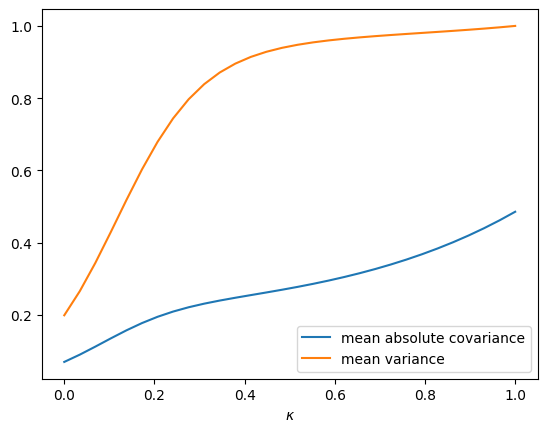

In [4]:
plt.plot(kappas, C)
plt.plot(kappas, D)
plt.xlabel('$\kappa$')
plt.legend(['mean absolute covariance', 'mean variance']);

In [5]:
C


array([0.06970666, 0.08988161, 0.11210597, 0.13503756, 0.15718083,
       0.17728691, 0.19464332, 0.20912968, 0.2210734 , 0.23103225,
       0.23961157, 0.24735659, 0.25471067, 0.26201403, 0.26952019,
       0.2774173 , 0.28584749, 0.2949228 , 0.30473638, 0.31537133,
       0.3269065 , 0.33942038, 0.35299402, 0.36771283, 0.38366726,
       0.40095329, 0.41967222, 0.43992889, 0.46183056, 0.48548242])

In [6]:
D

array([0.19879635, 0.26569283, 0.34396568, 0.42992905, 0.51816064,
       0.60279459, 0.679012  , 0.74398649, 0.79697508, 0.83878118,
       0.87103409, 0.89560056, 0.91422987, 0.92839491, 0.9392612 ,
       0.94771582, 0.95441878, 0.95985532, 0.96438128, 0.96825868,
       0.97168291, 0.97480345, 0.97773713, 0.98057997, 0.98341417,
       0.9863137 , 0.98934942, 0.99259096, 0.99611139, 0.9999848 ])